In [1]:
!pip install dgl

In [2]:
!pip install geoopt
!pip install geomstats
!pip install dgl
!pip install torch

In [3]:
import logging
import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization

from geomstats.datasets.utils import load_karate_graph
from geomstats.geometry.poincare_ball import PoincareBall

In [4]:
import random
import numpy as np
import torch
import dgl.data

### Load the Dataset

In [5]:
import dgl
from dgl.data import CoraGraphDataset
cora_dataset = CoraGraphDataset()
cora_ml = cora_dataset[0]

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [6]:
import dgl
from dgl.data import CoraFull

# Load the Cora-Full dataset
cora_full_dataset = CoraFull()
cora_full = cora_full_dataset[0]

/opt/conda/lib/python3.10/site-packages/dgl/data/utils.py:377: UserWarning: Class CoraFull will be deprecated, please use CoraFullDataset instead.
  warnings.warn(


### The framework starts here:
1. First sample the base graph
2. the problem encounter is a n-way, k-shot. Thus, we enact the same for the base graph
3. Perform base-training: Episodic learning
4. Save the best model
5. Perform Fine-tuning for new-streams of data

Load the necessary values for the framework

In [7]:
Original_graph = cora_ml   #DGL object
base_classes_graph = 2
num_support_base = 5
num_query_base = 10
start_seed_base = 100
num_episodes_base = 200
graph_feats_size = Original_graph.ndata['feat'].shape[1]
n_seed = 42


fixed_list = [52, 46, 11, 24, 52, 70, 66, 41, 162, 1110]
starting_seeds = [425, 310, 20,180, 535, 110, 195, 233, 541, 945]
"""
meta_lr = 0.00001
"""


'\nmeta_lr = 0.00001\n'

In [8]:
import torch
import numpy as np
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim


def generate_semantic_embeddings(class_names_dict, embedding_dim= 512):
    # Tokenize class names
    tokenized_class_names = [word_tokenize(class_name.lower()) for class_name in class_names_dict.values()]
    
    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_class_names, vector_size = embedding_dim, window=5, min_count=1, workers=40)
    
    # Access the learned embeddings
    label_embeddings = {label: torch.tensor(model.wv[label]) for label, class_name in class_names_dict.items()}
    
    return label_embeddings


# Example usage:
class_names_dict = {0: "Theory",
                    1: "Reinforcement_learning",
                    2: "Genetic_algorithms",
                    3: "Neural_networks",
                    4: "Probabilistic_methods",
                    5: "Case_based",
                    6: "Rule_learning"}
semantic_embeddings = generate_semantic_embeddings(class_names_dict)


# def custom_loss(embeddings):
#     loss = 0
#     for label_i, embed_i in embeddings.items():
#         for label_j, embed_j in embeddings.items():
#             if label_i != label_j:
#                 loss_semantics = -torch.log(torch.norm(embed_i - embed_j))
#                 loss += loss_semantics   # Squared L2 distance
#     return loss

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(NeuralNetwork, self).__init__()
#         self.fc = nn.Linear(input_size, hidden_size)

#     def forward(self, x):
#         out = self.fc(x)
#         return out

# # Sample dictionary with class labels as keys and feature tensors as values
# sample_data = semantic_embeddings

# input_size = 512  # Assuming each feature tensor has a shape of (1, 512)
# hidden_size = 7

# # Initialize neural network and loss function
# model = NeuralNetwork(input_size, hidden_size)
# criterion = custom_loss

# # Optimizer
# optimizer = optim.SGD(model.parameters(), lr=0.1)

# # Training loop
# num_epochs = 1000
# for epoch in range(num_epochs):
#     new_embeddings = {}
#     for label, embed in sample_data.items():
#         output = model(embed).squeeze()
#         new_embeddings[label] = output
#     loss = criterion(new_embeddings)

#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     #print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

    
# semantic_embeddings = {label: tensor.detach().clone() for label, tensor in new_embeddings.items()}


In [9]:
# semantic_embeddings

In [10]:
# import numpy as np

# # Extract values from the dictionary
# tensor_list = list(semantic_embeddings.values())

# # Concatenate tensors along a new axis
# concatenated_tensor = torch.stack(tensor_list)

# # Convert the tensor to a numpy array
# matrix_of_values = concatenated_tensor.detach().numpy()
# semantic_embeddings = matrix_of_values

In [11]:

# from scipy.spatial.distance import cdist
# distance_matrix = cdist(semantic_embeddings, semantic_embeddings, metric='euclidean')

# print(distance_matrix)

### Sample the graph with only required number of classes: For Cora, we have started with 5 classes. The classes are chosen randomly

In [12]:
import dgl
import numpy as np

def process_graph(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)
    remaining_classes -= set(p_classes)

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [13]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [14]:

# Example usage:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

# Sample a subgraph with 20 classes from the base graph
sampled_graph_base, _ = process_graph(
    Original_graph,
    num_classes_to_keep= base_classes_graph,
    random_seed = n_seed,
    remaining_classes=base_remaining_classes
)
print(f'Base graph classes: {get_unique_classes(sampled_graph_base)}')

Base graph classes: [0, 1]


### Meta-Data generator: we divide the graph into tasks; Each task is further divided into train and test set

In [15]:
import random
import numpy as np
import torch
import dgl.data

class MetaDataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, num_walks, walk_length):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.task_data = []

    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task = {}
            support_set = []
            query_set = []

            unique_classes = np.unique(self.dataset.ndata['label'].numpy())
            class_group = np.random.choice(unique_classes, self.num_classes, replace=False)

            for c in class_group:
                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace=False)
                query_indices = np.random.choice(indices, size=self.num_query, replace=False)

                support_set.extend(support_indices)
                query_set.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set)
            support_random_walks_list.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set)
            query_random_walks_list.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set + [node for walk in query_random_walks for node in walk]))
            task['test'] = test_set

            train_set = list(set(support_set + [node for walk in support_random_walks for node in walk]))
            task['train'] = train_set
            task['query_set'] = query_set
            task['support_set'] = support_set
            task['seed'] = task_seed

            tasks.append(task)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list.append(edge_indices_test)
            edge_indices_train_list.append(edge_indices_train)

        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list

    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks = []
        edge_indices_train_list = []
        edge_indices_test_list = []
        support_random_walks_list = []
        query_random_walks_list = []


        for seed in self.random_seeds:
            tasks_data, edges_train, edges_test, support_walks, query_walks = self.create_task(seed, self.task_random_seeds)
            tasks.extend(tasks_data)
            edge_indices_train_list.extend(edges_train)
            edge_indices_test_list.extend(edges_test)
            support_random_walks_list.extend(support_walks)
            query_random_walks_list.extend(query_walks)



        return tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list


### Once the tasks are generated and nodes are assigned to respective tasks we extract the features and labels accordingly

In [16]:
import torch
import dgl

def create_feature_label_extractor(graph, tasks):
    def feature_label_extractor(task_id, seed):
        task = tasks[task_id]

        train_set = task['train']
        test_set = task['test']
        support_set = task['support_set']  # Include support set
        query_set = task['query_set']  # Include query set

        # Extract features and labels for the entire graph
        all_features = graph.ndata['feat']
        all_labels = graph.ndata['label']

        # Extract features and labels for the train set
        train_features = all_features[train_set]
        train_labels = all_labels[train_set]

        # Extract features and labels for the test set
        test_features = all_features[test_set]
        test_labels = all_labels[test_set]

        # Extract features and labels for the support set
        support_features = all_features[support_set]
        support_labels = all_labels[support_set]

        # Extract features and labels for the query set
        query_features = all_features[query_set]
        query_labels = all_labels[query_set]

        # Calculate the degrees of nodes
        train_degrees = graph.in_degrees(train_set)
        test_degrees = graph.in_degrees(test_set)
        support_degrees = graph.in_degrees(support_set)
        query_degrees = graph.in_degrees(query_set)

        return (
            torch.tensor(train_features), torch.tensor(train_labels),
            torch.tensor(test_features), torch.tensor(test_labels),
            torch.tensor(support_features), torch.tensor(support_labels),
            torch.tensor(query_features), torch.tensor(query_labels),
            torch.tensor(train_degrees), torch.tensor(test_degrees),
            torch.tensor(support_degrees), torch.tensor(query_degrees)
        )

    return feature_label_extractor


In [17]:
import torch

def reindex_nodes(task_id, train_set_list, edge_indices_list, random_walks_list):
    # Extracting task-specific data
    train_set = train_set_list[task_id]
    src_train, dst_train = edge_indices_list[task_id]  # Assuming edge_indices_list is a list of tensors
    random_walks_train = random_walks_list[task_id]

    # Reindexing nodes in train_set
    node_mapping = {old_node: new_node for new_node, old_node in enumerate(train_set)}
    reindexed_train_set = [node_mapping[node] for node in train_set]

    # Reindexing nodes in edge_indices
    reindexed_edge_indices = torch.stack([
        torch.tensor([node_mapping.get(int(source), -1) for source in src_train], dtype=torch.long),
        torch.tensor([node_mapping.get(int(destination), -1) for destination in dst_train], dtype=torch.long)
    ], dim=0)

    # Filter out rows with missing nodes
    mask = (reindexed_edge_indices != -1).all(dim=0)
    reindexed_edge_indices = reindexed_edge_indices[:, mask]

    # Reindexing nodes in random_walks
    reindexed_random_walks = [
        [node_mapping.get(int(node), -1) for node in walk]
        for walk in random_walks_train
    ]

    # Filter out walks with missing nodes
    reindexed_random_walks = [walk for walk in reindexed_random_walks if -1 not in walk]

    # Create a dictionary for old to new node indices
    old_to_new_mapping = {old_node: new_node for old_node, new_node in node_mapping.items()}

    return reindexed_train_set, reindexed_edge_indices, reindexed_random_walks, old_to_new_mapping

In [18]:
def dict_for_custom_loss_function(reindexed_random_walks, old_to_new_mapping_train, graph):
    original_first_node_list = []
    remaining_nodes = []
    all_firsts = []

    for walks in reindexed_random_walks:
        reindexed_first_node = walks[0]
        all_firsts.append(reindexed_first_node)
        reindexed_remaining_nodes = walks[1:]
        #print(reindexed_remaining_nodes)

        # Find the corresponding original node index using the original-to-reindexed mapping
        original_first_node = next((old_node for old_node, new_node in old_to_new_mapping_train.items() if reindexed_first_node == new_node), None)
        original_first_node_list.append(original_first_node)
        remaining_nodes.append(reindexed_remaining_nodes)


    # Assuming original_labels is a dictionary with node indices as keys and labels as values
    labels_for_nodes = [graph.ndata['label'][node] for node in original_first_node_list if node is not None]

    return labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts

In [19]:
def create_label_dict(labels_for_nodes, remaining_nodes, all_firsts):
    final_list = []
    for i in range(len(labels_for_nodes)):
        final = [labels_for_nodes[i], remaining_nodes[i]]
        final_list.append(final)

    label_dict = {}
    for item in final_list:
        label = item[0].item()  # Convert tensor label to integer
        nodes_list = item[1]


        if label not in label_dict:
            label_dict[label] = nodes_list
        else:
            label_dict[label].extend(nodes_list)



    # Perform set operation to remove duplicates within each list
    for key in label_dict:
        label_dict[key] = list(set(label_dict[key]))

    return label_dict

In [20]:
!pip install torch_geometric

### ( Main code starting now)Prepare the data for learning the embeddings: the  steps are :

for each task
*   Get the (train, test)- nodes, features, labels, edge index
*   pass it through the hyperbolic generator to get the corresponding eucledian embeddings






In [21]:
import torch

def calculate_euclidean_prototype(features, degree_tensor, class_dict):
    # Initialize a dictionary to store prototypes for each class
    class_prototypes = {}

    for class_label, nodes in class_dict.items():
        # Extract features for the nodes in the current class
        class_features = features[nodes]

        # Extract degrees for the nodes in the current class
        class_degrees = degree_tensor[nodes]

        # Calculate the weighted sum of features
        weighted_sum = torch.sum(class_degrees.unsqueeze(1) * class_features, dim=0)

        # Calculate the sum of degrees
        sum_degrees = torch.sum(class_degrees)

        # Calculate the prototype (weighted average)
        prototype = weighted_sum / sum_degrees

        # Store the prototype in the dictionary
        class_prototypes[class_label] = prototype

    return class_prototypes

In [22]:
def get_unique_elements_in_order(input_list):
    unique_elements_set = set()
    unique_elements_list = []

    for element in input_list:
        if element not in unique_elements_set:
            unique_elements_set.add(element)
            unique_elements_list.append(element)

    return unique_elements_list

In [23]:
def add_elements_to_dictionary_list(reformulated_dict, unique_elements_result):
    for i, class_label in enumerate(reformulated_dict.keys()):
        # Get the row corresponding to the class label
        row_elements = unique_elements_result[i]

        # Add each element to the list in the dictionary
        for element in row_elements:
            reformulated_dict[class_label].append(element)

In [24]:
def create_C_dictionary(Reform_dict, proto_dict):
    # Ensure both dictionaries have the same keys
    common_keys = set(Reform_dict.keys()).intersection(proto_dict.keys())

    # Create a new dictionary with values from both dictionaries for common keys
    C_dict = {key: (Reform_dict[key], proto_dict[key]) for key in common_keys}

    # Access values individually
    Reform_values = {key: Reform_dict[key] for key in common_keys}
    Proto_values = {key: proto_dict[key] for key in common_keys}

    # Use values from proto_dict as keys in Reform_dict
    Reform_dict_with_proto_keys = {tuple((proto_dict[key]).numpy()): Reform_dict[key] for key in common_keys}

    return Reform_values, Proto_values, Reform_dict_with_proto_keys

In [25]:
import torch
import numpy as np
from torch_geometric.data import Data
import warnings
warnings.filterwarnings("ignore")

def base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds, semantic_vectors):
    train_indexes_before_reindexing_list = []
    test_indexes_before_reindexing_list = []
    task_datasets_euc = []
    context_dictionary_list = []
    train_set_list = []
    test_set_list = []
    euc_proto = []


    num_tasks = num_seeds
    
    metadata_generator = MetaDataGenerator(sampled_graph_base, num_tasks, num_classes, num_support, num_query, task_random_seeds, random_seeds, 10, 3)
    tasks, edge_indices_train_list, edge_indices_test_list, support_random_walks_list, query_random_walks_list = metadata_generator.generate_tasks()

    for i, task in enumerate(tasks):
        #print(f"Task = {i} - Seed: {task_random_seeds[i]}")
        seed = task_random_seeds[i]
        extractor = create_feature_label_extractor(graph, tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed) 
        train_indexes_before_reindexing_list.append(task['train'])
        train_set_list.append(task['train'])
        test_set_list.append(task['test'])
        test_indexes_before_reindexing_list.append(task['test'])
        
        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_indexes_before_reindexing_list, edge_indices_train_list, support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_indexes_before_reindexing_list, edge_indices_test_list, query_random_walks_list)
        
        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))
        
        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)
        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)
        
        unique_elements_result = get_unique_elements_in_order(all_firsts)
        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        context_dictionary_list.append(result_label_dict)
        eucledian_prototype = calculate_euclidean_prototype(train_features, train_degrees, result_label_dict)
        euc_proto.append(eucledian_prototype)
        Reform_values, Proto_values, Reform_dict_with_proto_keys = create_C_dictionary(result_label_dict, eucledian_prototype)
        
    return context_dictionary_list, task_datasets_euc

graph = sampled_graph_base
num_classes = base_classes_graph
num_support = num_support_base
num_query = num_query_base
start_seed = start_seed_base
spacing = 50
num_seeds = num_episodes_base
task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
random_seeds = [42]

context_dictionary_list, task_datasets_euc = base_training_task_generator(graph, num_classes, num_support, num_query, start_seed, spacing, num_seeds, task_random_seeds, random_seeds, semantic_embeddings)

In [26]:
!pip install torch_geometric

In [27]:
import torch

def create_new_proto(mean_vectors, semantic_vectors):
    new_proto_vectors = {}

    for label in mean_vectors.keys():
#         print(f'label shape(mean): {label.shape}')
        if label in semantic_vectors:
            #print(f'create proto: {label}')
#             print(f' shape(semantics): {semantic_vectors[label].shape}')
#             print(f' shape(mean): {mean_vectors[label].shape}')
            # Take the mean along the last dimension of the concatenated tensor
            new_vector = torch.mean(torch.stack([1 * mean_vectors[label],  1 * semantic_vectors[label]]), dim=0)
            new_proto_vectors[label] = new_vector
        else:
            # Handle the case where there is no corresponding semantic vector
            print(f"No semantic vector found for label {label}")

    return new_proto_vectors


In [28]:
import torch

def Lintra_loss(embeddings, context_dictionary, target_radius, semantic_vectors):
    loss_intra = 0
    num_clusters = len(context_dictionary)

    # Calculate mean vectors for each cluster
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
    mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
    # Calculate intra-cluster loss
    for j, cluster_elements in context_dictionary.items():
        mean_vector = mean_vectors[j]

        for i in cluster_elements:
            embedding_i = embeddings[i]
            norm_diff = torch.norm(embedding_i - mean_vector)
            loss_contrib = torch.clamp(norm_diff - target_radius, min=0)

            # Calculate the sum of all d_{ij} within the cluster
            sum_dij = torch.sum(torch.clamp(torch.norm(embeddings[cluster_elements] - mean_vector, dim=1) - target_radius, min=0))

            # Normalize dij by the sum of all dij within the cluster
            #normalized_dij = loss_contrib / sum_dij
            normalized_dij = loss_contrib 

            # Add the normalized contribution to the overall loss
            loss_intra += normalized_dij
            
    # Normalize the overall loss by the number of clusters
    loss_intra_normalized = loss_intra / num_clusters
    return loss_intra_normalized, mean_vectors


In [29]:
import torch

def Linter_loss(embeddings, context_dictionary, semantic_vectors):
    mean_vectors = {j: torch.mean(embeddings[cluster_elements], dim=0) for j, cluster_elements in context_dictionary.items()}
    mean_vectors = create_new_proto(mean_vectors, semantic_vectors)
    loss_inter = 0
    num_clusters = len(context_dictionary)

    for j, cluster_j in context_dictionary.items():
        for p, cluster_p in context_dictionary.items():
            if p != j and j in mean_vectors and p in mean_vectors:  # Check if keys exist
                norm_diff = -torch.log(torch.norm(mean_vectors[j] - mean_vectors[p]) )
                loss_inter += norm_diff
    loss_inter_normalised = loss_inter / num_clusters
    return loss_inter_normalised, mean_vectors

In [30]:
# import torch.nn.functional as F

# def L_proto(mean_vectors, semantic_embeddings):
#     semantic_loss = 0
    
#     for label, mean_vector in mean_vectors.items():
#         #print(f'label in proto: {label}')
#         semantic_embedding = semantic_embeddings[label]
#         loss = (torch.norm(mean_vector - semantic_embedding))
#         semantic_loss += loss
    
#     return semantic_loss, semantic_embedding


In [31]:
import torch

def L_proto(mean_vectors, semantic_embeddings):
    semantic_loss = 0
    semantic_embeddings_dict = {}
    
    for label, mean_vector in mean_vectors.items():
        semantic_embedding = semantic_embeddings[label]
        loss = torch.norm(mean_vector - semantic_embedding)
        semantic_loss += loss
        semantic_embeddings_dict[label] = semantic_embedding
    
    return semantic_loss, semantic_embedding, semantic_embeddings_dict


In [32]:
import torch
import torch.nn.functional as F

def accuracy_cosine(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        similarities = {label: F.cosine_similarity(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the maximum cosine similarity
        closest_label_sim = max(similarities, key=similarities.get)

        # If the closest label by cosine similarity matches the true label, consider it correct
        if closest_label_sim == labels[i].item():
            correct += 1

    return correct / total

In [33]:
def accuracy_euclidean(output, labels, mean_vectors):
    _, predicted = torch.max(output, 1)
    correct = 0
    total = labels.size(0)

    for i in range(total):
        output_node = output[i, :]
        distances = {label: torch.dist(output_node.unsqueeze(0), mean_vector.unsqueeze(0)) for label, mean_vector in mean_vectors.items()}

        # Find the label with the minimum Euclidean distance
        closest_label_dist = min(distances, key=distances.get)

        # If the closest label by Euclidean distance matches the true label, consider it correct
        if closest_label_dist == labels[i].item():
            correct += 1

    return correct / total

### Training stage: This part is called Base Training of the graph in meta-learning framework

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from tqdm import tqdm


class GATmodel(nn.Module):
    '''
    input x shape is [node_num, node_feature]
    output out shape is [node_num, class_num]
    '''
    def __init__(self, in_feature, hidden_feature, out_channels):
        super(GATmodel, self).__init__()
        self.in_feature = in_feature
        self.hidden_feature = hidden_feature
        self.out_channels = out_channels
        self.build()
        print("GATConv init.")

    def build(self):
        self.gat_layer_1 = GATConv(in_channels=self.in_feature, out_channels=self.hidden_feature, heads=3, concat=False)
        self.gat_layer_2 = GATConv(in_channels=self.hidden_feature, out_channels=self.out_channels, heads=3, concat=False)
    
    def forward(self, x, edge_index):
        gout_1 = self.gat_layer_1(x, edge_index)
        gout_2 = F.dropout(F.relu(gout_1), p=0.2)
        gout_2 = self.gat_layer_2(gout_2, edge_index)
        return gout_2
    
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNetwork, self).__init__()
        self.fc = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        out = self.fc(x)
        return out


def meta_train(meta_model, semantic_model, task_datasets, meta_lr, weight_decays, context_dictionary_list, semantic_vectors):
    optimizer_meta = optim.Adam(meta_model.parameters(), lr=meta_lr, weight_decay=weight_decays)
    optimizer_semantic = optim.Adam(semantic_model.parameters(), lr=0.0001, weight_decay=weight_decays)
    
    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data
        all_train_data.append(task_train_data)
        
        # Training phase
        meta_model.train()
        semantic_model.train()  # Set the semantic model to training mode
        optimizer_meta.zero_grad()
        optimizer_semantic.zero_grad()

        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        loss_intra, _ = Lintra_loss(train_output, context_dictionary_list[i], 0.01, semantic_vectors)
        loss_inter, mean_vectors = Linter_loss(train_output, context_dictionary_list[i], semantic_vectors)
        
        # Semantic model forward pass
        semantic_output = {}
        for label, embed in semantic_vectors.items():
            output = semantic_model(embed).squeeze()
            semantic_output[label] = output
            #print(f'here shape: {semantic_output[label].shape}')
            
        # Calculate semantic loss
        semantic_loss, semantic_output, semantic_embeddings_dict = L_proto(mean_vectors, semantic_output)
        
        # Backpropagate through semantic model
        semantic_loss.backward(retain_graph=True)  # Specify retain_graph=True
        optimizer_semantic.step()
        
        loss = 1 * loss_intra + 0.25 * loss_inter
        loss.backward()
        optimizer_meta.step()

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)
        
        print(f'task = {i}, loss = {loss.item():.2f}, loss_semantic = {semantic_loss.item():.2f}, test acc = {test_acc:.2f}%')

    return meta_model, semantic_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies


In [35]:
# Example usage:
in_channels = 1433
hidden_channels = 512
out_channels = 512
meta_lr = 0.00001
weight_decays = 5e-3  # List of weight decay values for each task

input_size = 512  # Assuming each feature tensor has a shape of (1, 512)
hidden_size = 512


In [36]:
# semantic_vectors

In [37]:
import time
from scipy.spatial.distance import cdist


# Record the start time
start_time = time.time()

# Instantiate the meta-model only once outside the loop
meta_model = GATmodel(in_channels, hidden_channels, out_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)
semantic_vectors = semantic_embeddings

semantic_model = NeuralNetwork(input_size, hidden_size)
semantic_model = semantic_model.to(device)

# Train the meta-learning model with regularization
model, semantic_model, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = meta_train(meta_model, semantic_model, task_datasets_euc, meta_lr, weight_decays, context_dictionary_list, semantic_vectors)

# Find the episode number and corresponding accuracy with the highest accuracy
best_episode = max(task_dictionary, key=task_dictionary.get)
best_accuracy = task_dictionary[best_episode]

# Print the result
print(f"The best accuracy is {best_accuracy:.2f} at episode number {best_episode}.")

# Save the trained model
torch.save(model.state_dict(), 'meta_model.pth')
torch.save(semantic_model.state_dict(), 'semantic_model.pth')

# Record the end time
end_time = time.time()

# Calculate and print the execution time
execution_time = end_time - start_time
print(f'Total execution time: {execution_time} seconds')


GATConv init.
task = 0, loss = 1.26, loss_semantic = 1.16, test acc = 85.37%
task = 1, loss = 1.21, loss_semantic = 1.16, test acc = 91.04%
task = 2, loss = 1.24, loss_semantic = 1.15, test acc = 63.96%
task = 3, loss = 1.25, loss_semantic = 1.15, test acc = 84.73%
task = 4, loss = 1.28, loss_semantic = 1.14, test acc = 83.47%
task = 5, loss = 1.23, loss_semantic = 1.14, test acc = 80.49%
task = 6, loss = 1.16, loss_semantic = 1.13, test acc = 85.71%
task = 7, loss = 1.24, loss_semantic = 1.13, test acc = 82.31%
task = 8, loss = 1.16, loss_semantic = 1.12, test acc = 93.60%
task = 9, loss = 1.16, loss_semantic = 1.12, test acc = 91.24%
task = 10, loss = 1.23, loss_semantic = 1.12, test acc = 92.31%
task = 11, loss = 1.25, loss_semantic = 1.11, test acc = 91.95%
task = 12, loss = 1.22, loss_semantic = 1.11, test acc = 80.39%
task = 13, loss = 1.22, loss_semantic = 1.10, test acc = 85.94%
task = 14, loss = 1.20, loss_semantic = 1.10, test acc = 92.59%
task = 15, loss = 1.23, loss_semanti

In [38]:
# import matplotlib.pyplot as plt

# def plot_performance(task_train_losses, task_test_accuracies):
#     """
#     Plots the training losses and test accuracies for a given task.

#     Parameters:
#     - task_train_losses (list): List of training losses for each epoch.
#     - task_test_accuracies (list): List of test accuracies for each epoch.
#     """
#     epochs = range(1, len(task_train_losses) + 1)

#     # Plotting training losses
#     plt.figure(figsize=(5, 5))
#     plt.subplot(2, 1, 1)
#     plt.plot(epochs, task_train_losses, 'b', label='Training Loss')
#     plt.title('Training Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()

#     # Plotting test accuracies
#     plt.subplot(2, 1, 2)
#     plt.plot(epochs, task_test_accuracies, 'r', label='Test Accuracy')
#     plt.title('Test Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()
    
# plot_performance(task_train_losses, task_test_accuracies)

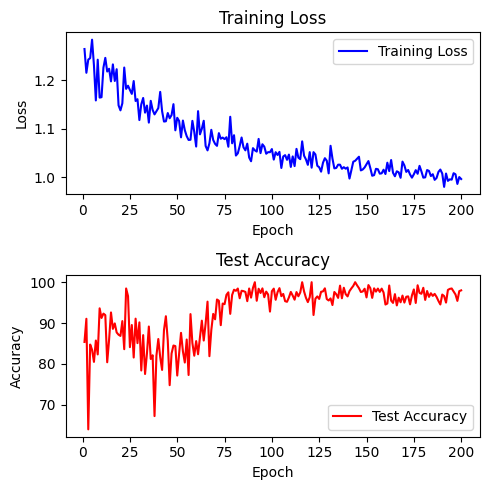

In [39]:
import matplotlib.pyplot as plt

def plot_performance(task_train_losses, task_test_accuracies, name=None):
    """
    Plots the training losses and test accuracies for a given task.

    Parameters:
    - task_train_losses (list): List of training losses for each epoch.
    - task_test_accuracies (list): List of test accuracies for each epoch.
    - name (str): Name to save the plot with. If None, the plot won't be saved.
    """
    epochs = range(1, len(task_train_losses) + 1)

    # Plotting training losses
    plt.figure(figsize=(5, 5))
    plt.subplot(2, 1, 1)
    plt.plot(epochs, task_train_losses, 'b', label='Training Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting test accuracies
    plt.subplot(2, 1, 2)
    plt.plot(epochs, task_test_accuracies, 'r', label='Test Accuracy')
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    
    # Save the plot with the specified name if provided
    if name:
        plt.savefig(f"{name}.png")
    
    plt.show()


plot_performance(task_train_losses, task_test_accuracies, name = 'base training')

In [40]:
# Print the result
print(f"The best accuracy is {best_accuracy:.2f}% at episode number: {best_episode}.")

The best accuracy is 100.00% at episode number: 90.


In [41]:
def consolidate_cluster_means(cluster_means, best_episode):
    if best_episode < 0 or best_episode >= len(cluster_means):
        raise ValueError("best_episode index is out of range")

    # Access the dictionary corresponding to the best episode
    best_episode_dict = cluster_means[best_episode][0]

    return best_episode_dict

In [42]:
# import matplotlib.pyplot as plt
# import numpy as np
# import torch

# def plot_cluster_means_tsne(coordinates, figsize=(2, 2)):
#     # Convert coordinates to numpy array
#     coordinates_array = np.array([coord.detach().numpy() if isinstance(coord, torch.Tensor) else coord for coord in coordinates.values()])

#     # Plotting
#     fig, ax = plt.subplots(figsize=figsize)  # Specify the figure size
#     for i, (label, coord) in enumerate(coordinates.items()):
#         if isinstance(coord, torch.Tensor):
#             coord = coord.detach().numpy()
#         ax.scatter(coord[0], coord[1], label=f'Class {label}')
#         ax.annotate(f'{label}', (coord[0], coord[1]), textcoords="offset points", xytext=(0,5), ha='center')

#     # Add labels and legend
#     ax.set_xlabel('Dimension 1')
#     ax.set_ylabel('Dimension 2')
#     ax.set_title('Visualization of Class Prototypes')

#     # Add grid lines
#     ax.grid(True)

#     # Show the plot
#     plt.show()


# plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode), figsize=(2, 2))


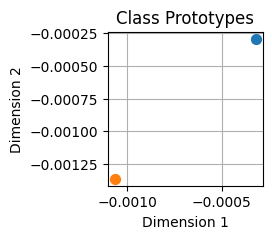

In [43]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def plot_cluster_means_tsne(coordinates, figsize=(2, 2), name=None):
    # Convert coordinates to numpy array
    coordinates_array = np.array([coord.detach().numpy() if isinstance(coord, torch.Tensor) else coord for coord in coordinates.values()])

    # Plotting
    fig, ax = plt.subplots(figsize=figsize)  # Specify the figure size
    for i, (label, coord) in enumerate(coordinates.items()):
        if isinstance(coord, torch.Tensor):
            coord = coord.detach().numpy()
        ax.scatter(coord[0], coord[1], label=f'Class {label}', marker='o',s= 50)
        #ax.annotate(f'{label}', (coord[0], coord[1]), textcoords="offset points", xytext=(0.1,0.1), ha='center')

    # Add labels and legend
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title('Class Prototypes')

    # Remove ticks and labels from the x and y axes
#     ax.set_xticks([])
#     ax.set_yticks([])
#     ax.xaxis.set_visible(True)
#     ax.yaxis.set_visible(True)
    
    # Add grid lines
    ax.grid(True)

    # Save the plot with the specified name if provided
    if name:
        plt.savefig(f"{name}.png")

    # Show the plot
    plt.show()


plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode), figsize=(2, 2), name = 'base clusters')

In [44]:
# break

### Finetuning:
1. Load the pre-trained model
2. Create incremental graph streams
3. finetune the model

In [45]:
meta_model = GATmodel(in_channels, hidden_channels, out_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
meta_model = meta_model.to(device)

GATConv init.


In [46]:
# Load the saved model
loaded_model = GATmodel(in_channels, hidden_channels, out_channels)
loaded_model.load_state_dict(torch.load('/kaggle/working/meta_model.pth'))
loaded_model = loaded_model.to(device)
print(loaded_model)

GATConv init.
GATmodel(
  (gat_layer_1): GATConv(1433, 512, heads=3)
  (gat_layer_2): GATConv(512, 512, heads=3)
)


In [47]:
# Instantiate a new semantic_model
semantic_model_loaded = NeuralNetwork(input_size, hidden_size)
# Load the saved parameters
semantic_model_loaded.load_state_dict(torch.load('semantic_model.pth'))

<All keys matched successfully>

In [48]:
import dgl
import numpy as np

def process_incremental_graphs(graph, num_classes_to_keep, random_seed=None, remaining_classes=None):
    # Fix the random seed
    if random_seed is not None:
        np.random.seed(random_seed)

    # Step 1: Identify the number of classes in the graph
    num_classes = len(np.unique(graph.ndata['label'].numpy()))

    # Step 2: Validate the given number of classes to keep
    if not 0 < num_classes_to_keep <= num_classes:
        raise ValueError("Invalid number of classes to keep.")

    # Step 3: Initialize remaining classes if not provided
    if remaining_classes is None:
        remaining_classes = set(range(num_classes))

    # Step 4: Sample classes without replacement until all classes are exhausted
    if len(remaining_classes) < num_classes_to_keep:
        raise ValueError("Not enough remaining classes to sample.")

    p_classes = np.random.choice(list(remaining_classes), size=num_classes_to_keep, replace=False)


    #print(f"Sampled Classes: {p_classes}")

    # Step 5: Sample nodes corresponding to the specified classes without replacement
    p_nodes = [i for i in range(graph.number_of_nodes()) if graph.ndata['label'][i].item() in p_classes]
    sampled_graph = dgl.node_subgraph(graph, p_nodes)

    # Step 6: Extract node labels and features corresponding to sampled nodes
    sampled_labels = sampled_graph.ndata['label']
    sampled_features = graph.ndata['feat'][p_nodes]  # Replace 'feat' with the actual feature name

    # Step 7: Set the features for the sampled graph
    sampled_graph.ndata['feat'] = sampled_features

    # Step 8: Create a new DGL graph object with sampled features and labels
    new_graph = dgl.graph((sampled_graph.edges()[0], sampled_graph.edges()[1]), num_nodes=sampled_graph.number_of_nodes())
    new_graph.ndata['label'] = sampled_labels
    new_graph.ndata['feat'] = sampled_features  # Replace 'feat' with the actual feature name

    return new_graph, remaining_classes

In [49]:
import random
import numpy as np
import torch
import dgl.data
from collections import OrderedDict

class FineTune_DataGenerator:
    def __init__(self, dataset, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, num_walks, walk_length, stream_seed):
        self.dataset = dataset
        self.num_tasks = num_tasks
        self.num_classes = num_classes
        self.num_support = num_support
        self.num_query = num_query
        self.task_random_seeds = task_random_seeds
        self.random_seeds = random_seeds
        self.num_walks = num_walks
        self.walk_length = walk_length
        self.base_classes = base_classes
        self.novel_classes_list = novel_classes_list
        self.stream_seed = stream_seed
        self.task_data = []


    def set_random_seed(self, seed):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)

    def create_task(self, seed, task_random_seeds, base_classes, novel_classes_list):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []

        for task_seed in task_random_seeds:
            self.set_random_seed(task_seed)
            task_base_unique_classes = {}
            task_last_k_classes = {}
            support_set_last_k_classes = []
            support_set_base_unique_classes = []
            query_set_last_k_classes = []
            query_set_base_unique_classes = []




            for c in base_classes:

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= False)
                query_indices = np.random.choice(indices, size=self.num_query, replace= False)

                support_set_base_unique_classes.extend(support_indices)
                query_set_base_unique_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_base_unique_classes)
            support_random_walks_list_base_unique_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_base_unique_classes)
            query_random_walks_list_base_unique_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_base_unique_classes + [node for walk in query_random_walks for node in walk]))
            task_base_unique_classes['test'] = test_set

            train_set = list(set(support_set_base_unique_classes + [node for walk in support_random_walks for node in walk]))
            task_base_unique_classes['train'] = train_set
            task_base_unique_classes['query_set'] = query_set_base_unique_classes
            task_base_unique_classes['support_set'] = support_set_base_unique_classes
            task_base_unique_classes['seed'] = task_seed

            tasks_base_unique_classes.append(task_base_unique_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_base_unique_classes.append(edge_indices_test)
            edge_indices_train_list_base_unique_classes.append(edge_indices_train)



            for c in novel_classes_list:
                np.random.seed(self.stream_seed)

                indices = np.where(self.dataset.ndata['label'].numpy() == c)[0]
                support_indices = np.random.choice(indices, size=self.num_support, replace= True)
                query_indices = np.random.choice(indices, size=self.num_query, replace= True)

                support_set_last_k_classes.extend(support_indices)
                query_set_last_k_classes.extend(query_indices)

            support_random_walks = self.generate_random_walks(support_set_last_k_classes)
            support_random_walks_list_last_k_classes.append(support_random_walks)

            query_random_walks = self.generate_random_walks(query_set_last_k_classes)
            query_random_walks_list_last_k_classes.append(query_random_walks)

            # Include query nodes and nodes from query random walks in the 'test' set
            test_set = list(set(query_set_last_k_classes + [node for walk in query_random_walks for node in walk]))
            task_last_k_classes['test'] = test_set

            train_set = list(set(support_set_last_k_classes + [node for walk in support_random_walks for node in walk]))
            task_last_k_classes['train'] = train_set
            task_last_k_classes['query_set'] = query_set_last_k_classes
            task_last_k_classes['support_set'] = support_set_last_k_classes
            task_last_k_classes['seed'] = task_seed

            tasks_last_k_classes.append(task_last_k_classes)

            # Generate edge indices for the combined set of query nodes and nodes from query random walks
            edge_indices_test = self.get_edges_from_nodes(test_set)
            edge_indices_train = self.get_edges_from_nodes(train_set)

            edge_indices_test_list_last_k_classes.append(edge_indices_test)
            edge_indices_train_list_last_k_classes.append(edge_indices_train)

        return tasks_last_k_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_last_k_classes, query_random_walks_list_last_k_classes, tasks_base_unique_classes, edge_indices_train_list_base_unique_classes, edge_indices_test_list_base_unique_classes, support_random_walks_list_base_unique_classes, query_random_walks_list_base_unique_classes



    def generate_random_walks(self, nodes):
        random_walks = []

        for node in nodes:
            for _ in range(self.num_walks):
                current_node = node
                walk = [current_node]
                for _ in range(self.walk_length - 1):
                    neighbors = list(self.dataset.successors(current_node).numpy())
                    if len(neighbors) > 0:
                        current_node = random.choice(neighbors)
                        walk.append(current_node)
                    else:
                        break
                random_walks.append(walk)

        return random_walks

    def get_edges_from_nodes(self, nodes):
        src, dst = [], []
        for node in nodes:
            successors = list(self.dataset.successors(node).numpy())
            for successor in successors:
                src.append(node)
                dst.append(successor)

        edge_index = torch.stack([torch.tensor(src), torch.tensor(dst)], dim=0).long()
        return edge_index

    def generate_tasks(self):
        tasks_base_unique_classes = []
        tasks_last_k_classes = []
        edge_indices_train_list_base_unique_classes = []
        edge_indices_train_list_last_k_classes = []
        edge_indices_test_list_base_unique_classes = []
        edge_indices_test_list_last_k_classes = []
        support_random_walks_list_base_unique_classes = []
        support_random_walks_list_last_k_classes = []
        query_random_walks_list_base_unique_classes = []
        query_random_walks_list_last_k_classes = []


        for seed in self.random_seeds:
            tasks_data_last_k_classes, edges_train_last_k_classes, edges_test_last_k_classes, support_walks_last_k_classes, query_walks_last_k_classes, tasks_data_base_unique_classes, edges_train_base_unique_classes, edges_test_base_unique_classes, support_walks_base_unique_classes, query_walks_base_unique_classes = self.create_task(seed, self.task_random_seeds, self.base_classes, self.novel_classes_list)
            tasks_base_unique_classes.extend(tasks_data_base_unique_classes)
            tasks_last_k_classes.extend(tasks_data_last_k_classes)
            edge_indices_train_list_base_unique_classes.extend(edges_train_base_unique_classes)
            edge_indices_train_list_last_k_classes.extend(edges_train_last_k_classes)
            edge_indices_test_list_base_unique_classes.extend(edges_test_base_unique_classes)
            edge_indices_test_list_last_k_classes.extend(edges_test_last_k_classes)
            support_random_walks_list_base_unique_classes.extend(support_walks_base_unique_classes)
            support_random_walks_list_last_k_classes.extend(support_walks_last_k_classes)
            query_random_walks_list_base_unique_classes.extend(query_walks_base_unique_classes)
            query_random_walks_list_last_k_classes.extend(query_walks_last_k_classes)


        return tasks_base_unique_classes, tasks_last_k_classes , edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes


In [50]:
import torch
from torch_geometric.data import Data
import numpy as np

def create_context_and_datasets(graph, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds):
    # Your existing code for generating random seeds
    task_random_seeds = [start_seed + i * spacing for i in range(num_seeds)]
    random_seeds = [42]
    num_tasks = num_seeds

    # Your existing code for generating tasks and extracting features
    metadata_generator = FineTune_DataGenerator(graph, num_tasks, num_classes, num_support, num_query, base_classes, novel_classes_list, task_random_seeds, random_seeds, 10, 3,  stream_seed)
    tasks_base_unique_classes, tasks_last_k_classes, edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes, edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes, support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes, query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes = metadata_generator.generate_tasks()

    # Your existing code for combining tasks
    combined_query_random_walks_list = [
        query_base + query_last_k
        for query_base, query_last_k in zip(query_random_walks_list_base_unique_classes, query_random_walks_list_last_k_classes)
    ]

    # Your existing code for combining edge indices
    combined_edge_indices_train_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_train_list_base_unique_classes, edge_indices_train_list_last_k_classes)
    ]

    combined_edge_indices_test_list = [
        torch.cat([edge_base, edge_last_k], dim=1)
        for edge_base, edge_last_k in zip(edge_indices_test_list_base_unique_classes, edge_indices_test_list_last_k_classes)
    ]

    # Your existing code for combining support random walks
    combined_support_random_walks_list = [
        support_base + support_last_k
        for support_base, support_last_k in zip(support_random_walks_list_base_unique_classes, support_random_walks_list_last_k_classes)
    ]

    combined_tasks = []
    for base_task, last_k_task in zip(tasks_base_unique_classes, tasks_last_k_classes):
        combined_task = {
            'test': base_task['test'] + last_k_task['test'],
            'train': base_task['train'] + last_k_task['train'],
            'query_set': base_task['query_set'] + last_k_task['query_set'],
            'support_set': base_task['support_set'] + last_k_task['support_set'],
            'seed': base_task['seed'],  # You may want to choose which seed to use
        }
        combined_tasks.append(combined_task)

    train_set_list = []
    test_set_list = []
    context_dictionary_list = []
    task_datasets_euc = []

    for i, task in enumerate(combined_tasks):
        #print(f"Episodes: {i} - Seed: {task['seed']}, streaming seed = {stream_seed}")
        seed = tasks_last_k_classes[i]['seed']
        extractor = create_feature_label_extractor(graph, combined_tasks)
        train_features, train_labels, test_features, test_labels, support_features, support_labels, query_features, query_labels, train_degrees, test_degrees, support_degrees, query_degrees = extractor(i, seed)

        train_set_list.append(task['train'])
        test_set_list.append(task['test'])

        reindexed_train_set, reindexed_edge_indices_train, reindexed_random_walks_train, old_to_new_mapping_train = reindex_nodes(i, train_set_list, combined_edge_indices_train_list, combined_support_random_walks_list)
        reindexed_test_set, reindexed_edge_indices_test, reindexed_random_walks_test, old_to_new_mapping_test = reindex_nodes(i, test_set_list, combined_edge_indices_test_list, combined_query_random_walks_list)

        data_train_euc = Data(x=train_features, edge_index=reindexed_edge_indices_train, y=train_labels)
        data_test_euc = Data(x=test_features, edge_index=reindexed_edge_indices_test, y=test_labels)
        task_datasets_euc.append((data_train_euc, data_test_euc))

        labels_for_nodes, remaining_nodes, original_first_node_list, all_firsts = dict_for_custom_loss_function(reindexed_random_walks_train, old_to_new_mapping_train, graph)

        result_label_dict = create_label_dict(labels_for_nodes, remaining_nodes, all_firsts)

        unique_elements_result = get_unique_elements_in_order(all_firsts)

        unique_elements_result = np.array(unique_elements_result).reshape(num_classes, num_support)
        # Add elements to the reformulated dictionary
        add_elements_to_dictionary_list(result_label_dict, unique_elements_result)
        # Print the reformulated dictionary after adding elements
        context_dictionary_list.append(result_label_dict)

    return context_dictionary_list, task_datasets_euc


In [51]:
def get_unique_classes(graph):
    """
    Extracts unique class labels from the 'label' attribute of a graph's node data.

    Parameters:
    - graph: The input graph.

    Returns:
    - list_of_classes: A list of unique class labels.
    """
    try:
        # Assuming 'label' is a tensor or NumPy array
        class_labels = graph.ndata['label'].numpy()
    except KeyError:
        # Adjust the key if the attribute name is different
        print("Error: 'label' attribute not found in node data.")
        return []

    # Extract unique class labels
    unique_classes = set(class_labels)

    # Convert the set to a list (order not guaranteed)
    list_of_classes = list(unique_classes)

    return list_of_classes

In [52]:
base_remaining_classes = set(range(len(np.unique(Original_graph.ndata['label'].numpy()))))  # Start with all classes

sampled_graph_base, _ = process_incremental_graphs(
    Original_graph,
    num_classes_to_keep= 3,
    random_seed=n_seed,
    remaining_classes=base_remaining_classes
)
get_unique_classes(sampled_graph_base)

[0, 1, 5]

knowledge distillation loss function

In [53]:
import torch

def KDloss(teacher_train_output, semantic_output_teacher, train_output, semantic_output, novel_classes, train_label):
    # Convert novel_classes to a tensor for comparison
    novel_classes_tensor = torch.tensor(novel_classes)

    # Find indices of rows in train_label corresponding to novel_classes
    novel_indices = torch.where(torch.isin(train_label, novel_classes_tensor))[0]

    # Create a boolean mask for filtering
    mask = torch.ones(len(train_label), dtype=torch.bool)
    mask[novel_indices] = False

    # Filter out the corresponding rows from teacher_train_output and train_output
    teacher_train_output_filtered = teacher_train_output[mask]
    train_output_filtered = train_output[mask]

    # Remove key-value pairs from semantic_output_teacher and semantic_output for novel classes
    for label in novel_classes:
        if label in semantic_output_teacher:
            del semantic_output_teacher[label]
        if label in semantic_output:
            del semantic_output[label]

    # Match and update semantic embeddings for common classes
    teacher_sem = []
    student_sem = []

    for label in semantic_output_teacher.keys():
        if label in semantic_output:
            # Concatenate semantic embeddings for the same class label
            teacher_sem.append(semantic_output_teacher[label])
            student_sem.append(semantic_output[label])

    # Stack the lists of embeddings along a new axis to create tensors
    teacher_sem = torch.stack(teacher_sem)
    student_sem = torch.stack(student_sem)

    # Now both the teacher and student for both node alignment and semantic alignment contain only those labels
    # from the previous stream

    # Node alignment loss
    squared_distance = torch.sum((torch.exp(teacher_train_output_filtered) - torch.exp(train_output_filtered)) ** 1, dim=1)
    # Average over samples
    N = teacher_train_output_filtered.size(0)
    node_loss = torch.mean(squared_distance) / N

    # Semantic alignment loss
    dot_product = torch.sum(teacher_sem * student_sem, dim=1)
    # Calculate norms
    teacher_norm = torch.norm(teacher_sem, dim=1)
    student_norm = torch.norm(student_sem, dim=1)
    # Calculate loss term
    loss_term = 1 - dot_product / (teacher_norm * student_norm)
    # Average over classes
    C = teacher_sem.size(0)
    semantic_alignment_loss = torch.mean(loss_term) / C

    return node_loss, semantic_alignment_loss


In [54]:
from collections import Counter

def fine_tune(teacher_model, teacher_model_semantic, novel_classes, meta_model, semantic_model, task_datasets, ft_lr, weight_decays, context_dictionary_list, semantic_vectors):
    optimizer_meta = optim.Adam(meta_model.parameters(), lr=meta_lr, weight_decay=weight_decays)
    optimizer_semantic = optim.Adam(semantic_model.parameters(), lr=0.01, weight_decay=weight_decays)

    total_losses = []  # List to store total losses over meta-epochs
    task_train_losses = []  # List to store task train losses over meta-epochs
    task_test_losses = [[] for _ in range(len(task_datasets))]  # List to store task test losses over meta-epochs
    task_train_accuracies = [[] for _ in range(len(task_datasets))]  # List to store task train accuracies over meta-epochs
    task_test_accuracies = []  # List to store task test accuracies 
    task_cluster_means = [[] for _ in range(len(task_datasets))]  # List to store task means over episodes
    all_train_data = []
    task_dictionary = {}

     

    # Inner loop (tasks)
    for i, task_data in enumerate(task_datasets):
        task_train_data, task_test_data = task_data

        all_train_data.append(task_train_data)
        
        # teacher model will be in evaluation mode
        teacher_model.eval()
        teacher_model_semantic.eval()
        semantic_output_teacher = {}
        for label, embed in semantic_vectors.items():
            output_teacher = teacher_model_semantic(embed).squeeze()
            semantic_output_teacher[label] = output_teacher
        
        #print(f'teacher: {semantic_output_teacher}')
        
        teacher_train_output = teacher_model(task_train_data.x, task_train_data.edge_index)
        #print(f'teacher train: {teacher_train_output}')
 
        
        # Training phase
        meta_model.train()
        semantic_model.train()  # Set the semantic model to training mode
        optimizer_meta.zero_grad()
        optimizer_semantic.zero_grad()
        
        # meta_model is the student model, student model will be in training phase
        train_output = meta_model(task_train_data.x, task_train_data.edge_index)  # Embeddings (train)
        #print(f'student train: {train_output}')
        
        train_label = task_train_data.y
        loss_intra, _ = Lintra_loss(train_output, context_dictionary_list[i], 0.01, semantic_vectors)
        loss_inter, mean_vectors = Linter_loss(train_output, context_dictionary_list[i], semantic_vectors)

        # Semantic model forward pass
        semantic_output = {}
        for label, embed in semantic_vectors.items():
            output = semantic_model(embed).squeeze()
            semantic_output[label] = output

            


        # Calculate semantic loss
        semantic_loss_proto, semantic_output, semantic_embeddings_dict = L_proto(mean_vectors, semantic_output)
        
        #print(f'student: {semantic_embeddings_dict}')
             
        
        # Calculate the knowledge distillation loss
        node_loss, semantic_alignment_loss = KDloss(teacher_train_output, semantic_output_teacher, train_output, semantic_embeddings_dict, novel_classes, train_label)
        

        # Backpropagate through semantic model
        
        semantic_loss = semantic_loss_proto + semantic_alignment_loss
        #print(f'node loss: {node_loss} and semantic loss: {semantic_alignment_loss}')
        #semantic_loss = semantic_loss_proto 
        semantic_loss.backward(retain_graph=True)  # Specify retain_graph=True
        optimizer_semantic.step()
        
        loss = 1 * loss_intra + 0.25 * loss_inter + node_loss
        
        #loss = 1 * loss_intra + 0.25 * loss_inter 
        loss.backward()
        optimizer_meta.step()
        

        # Validation phase
        meta_model.eval()  # Set the model to evaluation mode
        test_output = meta_model(task_test_data.x, task_test_data.edge_index)
        test_acc = accuracy_cosine(test_output, task_test_data.y, mean_vectors) * 100
        task_dictionary[i] = test_acc
        # Append metrics to lists
        task_cluster_means[i].append(mean_vectors)
        task_train_losses.append(loss.item())
        task_test_accuracies.append(test_acc)

        print(f'task = {i}, loss = {loss.item():.2f}, loss_semantic = {semantic_loss.item():.2f}, test acc = {test_acc:.2f}%')


    # Return  meta-model, task cluster means and task dictionary
    return  meta_model, semantic_model, task_cluster_means, task_dictionary, task_train_losses, task_test_accuracies

Number of Classes (Base) = 2, Base classes are: [0, 1]
========================== Streaming session: 1 ==========================
Number of Classes (Base + Novel) = 3
Novel classes are: [5]
Base Classes: [0, 1]
Total Novel Classes List: [5]
task = 0, loss = 2.09, loss_semantic = 0.59, test acc = 65.28%
task = 1, loss = 2.09, loss_semantic = 0.50, test acc = 68.22%
task = 2, loss = 2.09, loss_semantic = 0.25, test acc = 61.50%
task = 3, loss = 2.09, loss_semantic = 0.38, test acc = 63.13%
task = 4, loss = 2.09, loss_semantic = 0.37, test acc = 66.22%
task = 5, loss = 2.09, loss_semantic = 0.22, test acc = 71.37%
task = 6, loss = 2.10, loss_semantic = 0.19, test acc = 63.38%
task = 7, loss = 2.09, loss_semantic = 0.26, test acc = 66.02%
task = 8, loss = 2.08, loss_semantic = 0.23, test acc = 69.75%
task = 9, loss = 2.07, loss_semantic = 0.15, test acc = 62.79%
task = 10, loss = 2.08, loss_semantic = 0.15, test acc = 63.76%
task = 11, loss = 2.07, loss_semantic = 0.17, test acc = 64.36%
t

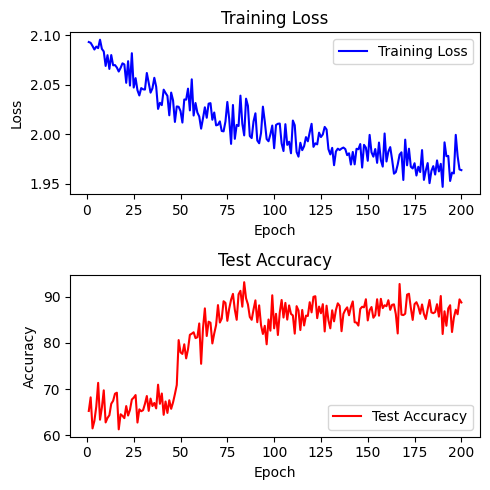

The best accuracy is 93.17% at episode number 83.


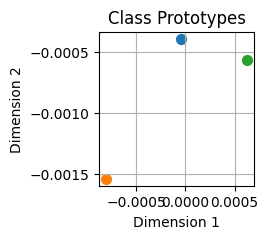

========================== Streaming session: 2 ==========================
Number of Classes (Base + Novel) = 4
Novel classes are: [2]
Base Classes: [0, 1]
Total Novel Classes List: [5, 2]
task = 0, loss = 3.05, loss_semantic = 0.05, test acc = 62.86%
task = 1, loss = 3.06, loss_semantic = 1.02, test acc = 60.36%
task = 2, loss = 3.05, loss_semantic = 0.74, test acc = 62.19%
task = 3, loss = 3.05, loss_semantic = 0.45, test acc = 63.14%
task = 4, loss = 3.04, loss_semantic = 0.42, test acc = 62.19%
task = 5, loss = 3.05, loss_semantic = 0.42, test acc = 64.34%
task = 6, loss = 3.04, loss_semantic = 0.40, test acc = 63.76%
task = 7, loss = 3.02, loss_semantic = 0.39, test acc = 62.81%
task = 8, loss = 3.03, loss_semantic = 0.34, test acc = 60.98%
task = 9, loss = 3.05, loss_semantic = 0.27, test acc = 60.07%
task = 10, loss = 3.02, loss_semantic = 0.26, test acc = 55.94%
task = 11, loss = 3.03, loss_semantic = 0.27, test acc = 64.64%
task = 12, loss = 3.05, loss_semantic = 0.25, test ac

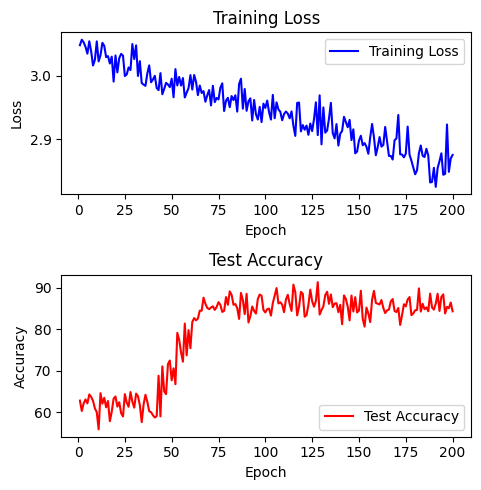

The best accuracy is 91.30% at episode number 127.


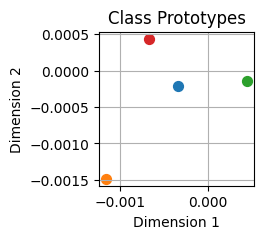

========================== Streaming session: 3 ==========================
Number of Classes (Base + Novel) = 5
Novel classes are: [4]
Base Classes: [0, 1]
Total Novel Classes List: [5, 2, 4]
task = 0, loss = 3.96, loss_semantic = 0.05, test acc = 69.15%
task = 1, loss = 3.93, loss_semantic = 1.24, test acc = 61.60%
task = 2, loss = 3.96, loss_semantic = 0.87, test acc = 63.94%
task = 3, loss = 3.94, loss_semantic = 0.54, test acc = 66.57%
task = 4, loss = 3.93, loss_semantic = 0.53, test acc = 64.58%
task = 5, loss = 3.95, loss_semantic = 0.51, test acc = 63.69%
task = 6, loss = 3.92, loss_semantic = 0.47, test acc = 65.04%
task = 7, loss = 3.96, loss_semantic = 0.45, test acc = 62.89%
task = 8, loss = 3.94, loss_semantic = 0.39, test acc = 67.30%
task = 9, loss = 3.90, loss_semantic = 0.33, test acc = 63.11%
task = 10, loss = 3.96, loss_semantic = 0.34, test acc = 68.31%
task = 11, loss = 3.95, loss_semantic = 0.33, test acc = 64.63%
task = 12, loss = 3.92, loss_semantic = 0.28, test

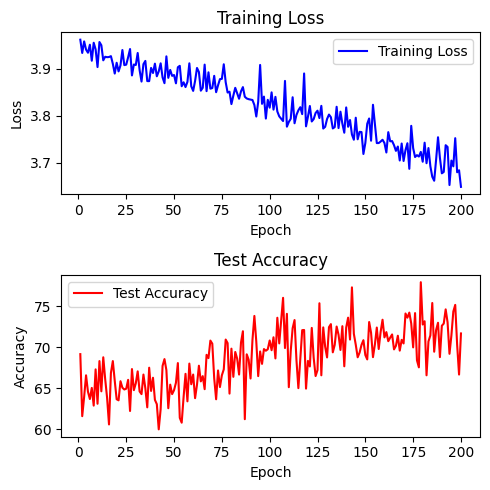

The best accuracy is 77.90% at episode number 178.


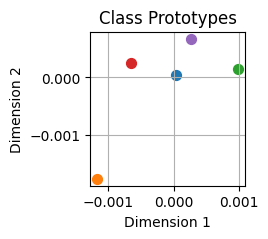

========================== Streaming session: 4 ==========================
Number of Classes (Base + Novel) = 6
Novel classes are: [3]
Base Classes: [0, 1]
Total Novel Classes List: [5, 2, 4, 3]
task = 0, loss = 4.87, loss_semantic = 0.07, test acc = 63.60%
task = 1, loss = 4.83, loss_semantic = 1.48, test acc = 66.02%
task = 2, loss = 4.99, loss_semantic = 1.09, test acc = 60.77%
task = 3, loss = 4.90, loss_semantic = 0.67, test acc = 63.34%
task = 4, loss = 4.90, loss_semantic = 0.62, test acc = 59.04%
task = 5, loss = 4.85, loss_semantic = 0.61, test acc = 66.74%
task = 6, loss = 4.95, loss_semantic = 0.59, test acc = 60.25%
task = 7, loss = 4.93, loss_semantic = 0.56, test acc = 61.60%
task = 8, loss = 4.96, loss_semantic = 0.47, test acc = 60.81%
task = 9, loss = 4.88, loss_semantic = 0.39, test acc = 64.69%
task = 10, loss = 4.91, loss_semantic = 0.39, test acc = 66.01%
task = 11, loss = 4.86, loss_semantic = 0.40, test acc = 62.66%
task = 12, loss = 4.85, loss_semantic = 0.35, t

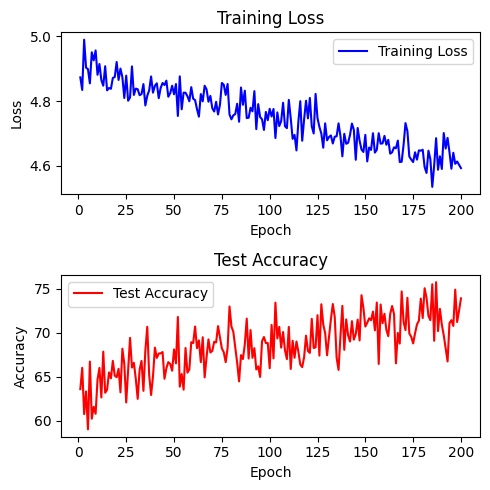

The best accuracy is 75.74% at episode number 186.


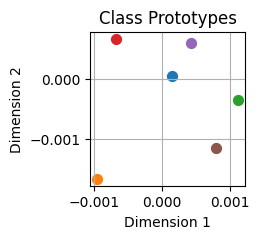

========================== Streaming session: 5 ==========================
Number of Classes (Base + Novel) = 7
Novel classes are: [6]
Base Classes: [0, 1]
Total Novel Classes List: [5, 2, 4, 3, 6]
task = 0, loss = 5.74, loss_semantic = 0.10, test acc = 62.55%
task = 1, loss = 5.72, loss_semantic = 1.71, test acc = 63.01%
task = 2, loss = 5.75, loss_semantic = 1.25, test acc = 66.73%
task = 3, loss = 5.70, loss_semantic = 0.81, test acc = 66.60%
task = 4, loss = 5.75, loss_semantic = 0.78, test acc = 68.53%
task = 5, loss = 5.76, loss_semantic = 0.73, test acc = 65.83%
task = 6, loss = 5.74, loss_semantic = 0.65, test acc = 67.11%
task = 7, loss = 5.72, loss_semantic = 0.64, test acc = 67.70%
task = 8, loss = 5.69, loss_semantic = 0.60, test acc = 66.54%
task = 9, loss = 5.72, loss_semantic = 0.51, test acc = 66.60%
task = 10, loss = 5.74, loss_semantic = 0.46, test acc = 63.50%
task = 11, loss = 5.69, loss_semantic = 0.44, test acc = 64.79%
task = 12, loss = 5.68, loss_semantic = 0.40

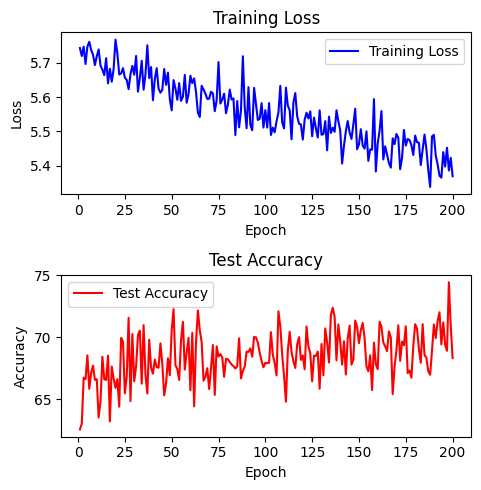

The best accuracy is 74.44% at episode number 197.


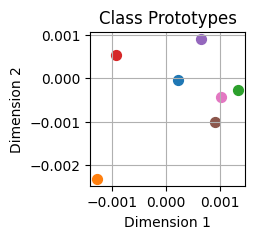

In [55]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

streaming_seeds = fixed_list
starting_seeds = starting_seeds
semantic_vectors = semantic_embeddings

previous_classes = set()  # Initialize an empty set outside the loop
base_classes_list = []    # Initialize an empty list for base classes
novel_classes_list = []   # Initialize an empty list for novel classes
p = 0
for i in range(2, 8, 1):

    sampled_graph_base, _ = process_incremental_graphs(
        Original_graph,
        num_classes_to_keep = i,
        random_seed = n_seed,
        remaining_classes=base_remaining_classes
    )

    all_classes = get_unique_classes(sampled_graph_base)

    if i == 2 :
        base_classes = list(set(all_classes))
        base_classes_list.extend(all_classes)  # Append base classes to the list
        print(f'Number of Classes (Base) = {i}, Base classes are: {base_classes}')
    else:
        print(f"========================== Streaming session: {p+1} ==========================")
        print(f'Number of Classes (Base + Novel) = {i}')
        novel_classes = list(set(all_classes) - previous_classes)
        novel_classes_list.extend(novel_classes)  # Append novel classes to the list
        print(f'Novel classes are: {novel_classes}')
        stream_seed = streaming_seeds[p]
        start_seed = starting_seeds[p]
        p += 1

        # Print the total novel classes list at each step only for i > 20
        print(f'Base Classes: {base_classes}')
        print(f'Total Novel Classes List: {novel_classes_list}')

        num_classes = i
        num_support = 5
        num_query = 10
        spacing = 50
        num_seeds = 200   #number of episodes in each stream
        ft_lr = 0.00001

        context_dictionary_list, task_datasets_eucledian = create_context_and_datasets(sampled_graph_base, num_classes, num_support, num_query, base_classes, novel_classes_list, stream_seed, start_seed, spacing, num_seeds)
        # Train the meta-learning model with regularization
        teacher_model = loaded_model
        teacher_model_semantic = semantic_model_loaded
        current_model, semantic_model_current, cluster_means, task_dictionary, task_train_losses, task_test_accuracies = fine_tune(teacher_model, teacher_model_semantic, novel_classes, loaded_model, semantic_model_loaded, task_datasets_eucledian, ft_lr, weight_decays, context_dictionary_list, semantic_vectors)
        loaded_model = current_model
        loaded_model_semantic = semantic_model_current
        # Find the episode number and corresponding accuracy with the highest accuracy
        best_episode = max(task_dictionary, key=task_dictionary.get)
        best_accuracy = task_dictionary[best_episode]
        
        # Save the model after each streaming session
        model_name = f'streaming_model_{p}.pt'
        torch.save(model.state_dict(), model_name)
        print(f'Model saved as: {model_name}')
        
        
        
        # Print the result
        name = f'streaming_{p}_training_plot'
        plot_performance(task_train_losses, task_test_accuracies,name = name )
        print(f"The best accuracy is {best_accuracy:.2f}% at episode number {best_episode}.")
        name = f'streaming_{p}_cluster_means'
        plot_cluster_means_tsne(consolidate_cluster_means(cluster_means, best_episode), name = name)
       
        plt.close()  # Close the current plot to avoid overlapping with the next iteration
        
        
        
        


    previous_classes = set(all_classes)
